<h1> Data Analysis for REYeker</h1>

In [1]:
import pandas as pd
from PIL import Image
import numpy as np
import re

<h2> Select Rows for Analysis</h2>

Setup the columns

In [2]:
path_to_data = r'./data/Book4.xlsx'

# columns with visual stimulus data
visual_stimulus_data = ['TR20_01', 'TI20_01', 'BR20_01', 'BI20_01']

# columns with time data of visual stimulus
time_data = []

# columns with the given answers of the studen
answer_fields = ['TR10_01', 'TI10_01', 'BR10_01', 'BI10_01']

# regex pattern for correct answer
right_answer_patterns = ['2', '2','2','2']

# colums of response time
response_time_data = ['TIME042', 'TIME008', 'TIME059', 'TIME023']

total_colums = []

# create all dataframe headers
for i in range(len(visual_stimulus_data)):
    tmp_list = []
    tmp_list.append(visual_stimulus_data[i])
    
    if len(time_data) != 0:
        tmp_list.append(time_data[i])
    tmp_list.append(answer_fields[i])
    tmp_list.append(response_time_data[i])
    total_colums.append(tmp_list)

Import the columns and create dataframe

In [3]:
dataframes = []
raw = pd.read_excel(path_to_data)

# read all dataframes
for data_set in total_colums:
    dataframe = pd.DataFrame(raw, columns = data_set)
    dataframe = dataframe.iloc[1:]
    dataframe = dataframe.dropna()
    dataframes.append(dataframe)

Splitting Dataframes in right and wrong answers.

In [4]:
dataframes_right = []
dataframes_wrong = []

# iter over every dataframe
for idx, dataframe in enumerate(dataframes):
    right_answer_pattern = right_answer_patterns[i]
    regex = re.compile(right_answer_pattern)
    answer_field = answer_fields[idx]
    
    dataframe_right = pd.DataFrame(columns = total_colums[idx])
    dataframe_wrong = pd.DataFrame(columns = total_colums[idx])
    
    # iter over every row and check if the result is rightr
    for _index, row  in dataframe.iterrows():
        result = regex.match(str(row[answer_field]))
        if result is not None:
            dataframe_right = dataframe_right.append(row)
        else:
            dataframe_wrong = dataframe_wrong.append(row)
    
    
    
    dataframes_right.append(dataframe_right)
    dataframes_wrong.append(dataframe_wrong)

<h3> Select Outlier and other things </h3>

TODO

<h3>Import REYeker Settings</h3>

Import Settings

In [5]:
import modules.rEYEkerAnalysis as rEYEker

In [6]:
settings_file = "data/example.json"

In [7]:
(_data, _times, click_setting) = rEYEker.load_data_from_json("data/example.json")

Import Images

In [8]:
image_paths = ['images/TR/TR_Fibonacci.png',
               'images/TI/TI_Fibonacci.png',
               'images/BR/BR_Fibonacci.png',
               'images/BI/BI_Fibonacci.png']

In [9]:
images = []

# read in every image
for image_path in image_paths:
    img = rEYEker.load_image(image_path)
    images.append(img)

<h3> Cast Data to Valid format</h3>

Import the visual stimulus measured Data

In [10]:
visual_stimulus_data_array = []

#iter over every dataframe
for idx, dataframe in enumerate(dataframes_right):
    visual_stimulus_measurements = []
    visual_stimulus_row = visual_stimulus_data[idx]

    #iter over every row 
    for _idx, item in dataframe.iterrows():
        data_str = item[visual_stimulus_row]
        data_str = data_str.strip()
        coordinates_str = data_str.split(" ")
        coordinates = []
        
        # iter over every coordinate pair x-y
        for coordinate_str in coordinates_str:
            coordinate = coordinate_str.split("-")
            coordinate = (int(coordinate[0]), int(coordinate[1]))
            coordinates.append(coordinate)
            
        visual_stimulus_measurements.append(coordinates)
        
    visual_stimulus_data_array.append(visual_stimulus_measurements)

Import the Time Data

In [11]:
timestamps_data_array = []

#iter over every dataframe
for idx, dataframe in enumerate(dataframes_right):
    if len(time_data) <= idx:
        break
    time_measurements = []
    time_measurement_row = time_data[idx]

    #iter over every row 
    for _idx, item in dataframe.iterrows():
        data_str = item[time_measurement_row]
        data_str = data_str.strip()
        timestamps = data_str.split(" ")
        timestamps = [int(timestamp) for timestamp in timestamps]
        time_measurement_row.append(timestamps)
        
    timestamps_data_array.append(visual_stimulus_measurements)

<h3>Helper Functions</h3>

In [12]:
def save_images(ims, prefix):
    """
    :brief saves an array of images to a certain location incrementing the postfix by a number
    :param ims:    array of images (np.ndarray)
    :param prefix: prefeix with folder location, make sure the folders exist
    """
    
    #TODO create folders if there are none present
    for idx, data in enumerate(ims):
        data = data*255
        data = np.uint8(data)
        im = Image.fromarray(data)
        im.save(prefix + str(idx) + '.png')

<h3>1. Create Single Heatmaps</h3>

In [13]:
heatmaps_datasets_array = []

# iterate over all the datasets
for dataset_idx, stimulus_dataset in enumerate(visual_stimulus_data_array):
    time_stamp_array = None
    if len(timestamps_data_array) > dataset_idx:
        time_stamp_array = timestamps_data_array[dataset_idx]
    
    heatmap_array = []

    # iterate over all the measurements of the dataset
    for visual_idx, stimulus_measurement in enumerate(stimulus_dataset):
        times = None
        if time_stamp_array is not None and len(time_stamp_array) > visual_idx:
            times = time_stamp_array[visual_idx]
        
        im = rEYEker.draw_shape_heat_map(images[dataset_idx], stimulus_measurement,click_setting, times, should_copy=True)
        heatmap_array.append(im)
        
    heatmaps_datasets_array.append(heatmap_array)

In [14]:
heatmap_results_prefix = [
    'results/Heatmaps/TR/TR_Fibonacci_',
    'results/Heatmaps/TI/TI_Fibonacci_',
    'results/Heatmaps/BR/BR_Fibonacci_',
    'results/Heatmaps/BI/BI_Fibonacci_']

In [15]:
for idx, heatmap_array in enumerate(heatmaps_datasets_array):
    save_images(heatmap_array, heatmap_results_prefix[idx])

<h3>2. Create Single Heatmaps</h3>

In [16]:
average_heatmap_results_prefix = [
    'results/Average_Heatmaps/TR/TR_Fibonacci_',
    'results/Average_Heatmaps/TI/TI_Fibonacci_',
    'results/Average_Heatmaps/BR/BR_Fibonacci_',
    'results/Average_Heatmaps/BI/BI_Fibonacci_']

In [17]:
average_heatmaps = []

# iterate over all the datasets
for idx, stimulus_dataset in enumerate(visual_stimulus_data_array):
    image = images[idx]
    visual_measurements = visual_stimulus_data_array[idx]
    time_measurements = None
    if len(timestamps_data_array) > idx:
        time_measurements = timestamps_data_array[idx]
    im = rEYEker.draw_average_shape_heat_map_rel(image, visual_measurements, click_setting, 1.0, .0, time_measurements, should_copy=True)
    average_heatmaps.append(im)

In [18]:
for idx, average_heatmap in enumerate(average_heatmaps):
    average_heatmap = [average_heatmap]
    prefix = average_heatmap_results_prefix[idx]
    save_images(average_heatmap, prefix)

<h3>3. Create Sequence diagramms</h3>

In [19]:
sequence_diagrams_datasets_array = []

# iterate over all the datasets
for dataset_idx, stimulus_dataset in enumerate(visual_stimulus_data_array):
    #if time will be needed someday
    #time_stamp_array = None
    #if len(timestamps_data_array) > dataset_idx:
    #    time_stamp_array = timestamps_data_array[dataset_idx]
    
    sequence_diagram_array = []

    # iterate over all the measurements of the dataset
    for visual_idx, stimulus_measurement in enumerate(stimulus_dataset):
        #if time will be needed someday
        #times = None
        #if time_stamp_array is not None and len(time_stamp_array) > visual_idx:
        #    times = time_stamp_array[visual_idx]
        try:
            im = rEYEker.draw_vertical_line_diagram(images[dataset_idx], stimulus_measurement, should_copy=True)
            sequence_diagram_array.append(im)
        except:
            #TODO
            print("W.I.P.:", end='')
            print("to many clicks for dataset " + str(dataset_idx) + " datset " + str(visual_idx))
    sequence_diagrams_datasets_array.append(sequence_diagram_array)

W.I.P.:to many clicks for dataset 3 datset 14


In [20]:
heatmap_results_prefix = [
    'results/Sequence_Diagrams/TR/TR_Fibonacci_',
    'results/Sequence_Diagrams/TI/TI_Fibonacci_',
    'results/Sequence_Diagrams/BR/BR_Fibonacci_',
    'results/Sequence_Diagrams/BI/BI_Fibonacci_']

In [21]:
for idx, sequence_diagram_array in enumerate(sequence_diagrams_datasets_array):
    save_images(sequence_diagram_array, heatmap_results_prefix[idx])

<h3>4. Generate Code Flow diagramm</h3>

TODO

set regions of code and somehow construct the codeflow

<h3>5. Compare Sequence Diagram and Code Flow</h3>

TODO

maybe use needleman wunsch or see how many jumps are equal and which jumps that are

<h3>Outliers</h3>

In [111]:
dataframes_without_outliers = []
dataframes_without_outliers_right = []
dataframes_without_outliers_wrong = []

#iterate over all dataframes and remove outliers
for idx, dataframe in enumerate(dataframes):
    data = dataframe[response_time_data[idx]]
    cleared_dataframe = dataframe[data.between(data.quantile(.15), data.quantile(0.85))]
    dataframes_without_outliers.append(cleared_dataframe)
    
#iterate over all dataframes and remove outliers
for idx, dataframe in enumerate(dataframes_right):
    data = dataframe[response_time_data[idx]]
    cleared_dataframe = dataframe[data.between(data.quantile(.15), data.quantile(0.85))]
    dataframes_without_outliers_right.append(cleared_dataframe)
    
#iterate over all dataframes and remove outliers
for idx, dataframe in enumerate(dataframes_wrong):
    data = dataframe[response_time_data[idx]]
    cleared_dataframe = dataframe[data.between(data.quantile(.15), data.quantile(0.85))]
    dataframes_without_outliers_wrong.append(cleared_dataframe)

<h3> Analyse average of Data</h3>

In [113]:
mean_response_times_with = []
mean_response_times_right = []
mean_response_times_wrong = []

standard_deviation_response_times = []
standard_deviation_response_times_right = []
standard_deviation_response_times_wrong = []

median_response_times = []
median_response_times_right = []
median_response_times_wrong = []

# do it for all the data
for idx, dataframe in enumerate(dataframes_without_outliers):
    mean = dataframe[response_time_data[idx]].mean()
    standard = dataframe[response_time_data[idx]].std()
    median = dataframe[response_time_data[idx]].median()
    
    mean_response_times.append(mean)
    standard_deviation_response_times.append(standard)
    median_response_times.append(median)

# do it for all the right data
for idx, dataframe in enumerate(dataframes_without_outliers_right):
    mean = dataframe[response_time_data[idx]].mean()
    standard = dataframe[response_time_data[idx]].std()
    median = dataframe[response_time_data[idx]].median()
    
    mean_response_times_right.append(mean)
    standard_deviation_response_times_right.append(standard)
    median_response_times_right.append(median)

# do it for all the wrong data
for idx, dataframe in enumerate(dataframes_without_outliers_wrong):
    mean = dataframe[response_time_data[idx]].mean()
    standard = dataframe[response_time_data[idx]].std()
    median = dataframe[response_time_data[idx]].median()
    
    mean_response_times_wrong.append(mean)
    standard_deviation_response_times_wrong.append(standard)
    median_response_times_wrong.append(median)

In [141]:
import seaborn as sns


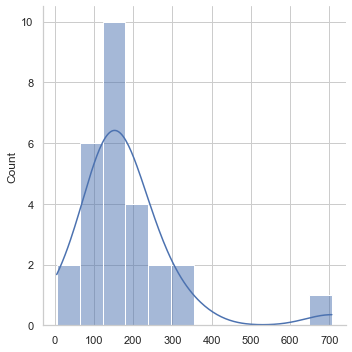

In [169]:
values = dataframes[0]["TIME042"].values.astype(float)
sns.displot(values, kde=True);

In [ ]:
#add joinplots when the outlier calculation is b4 the coordinates calculation

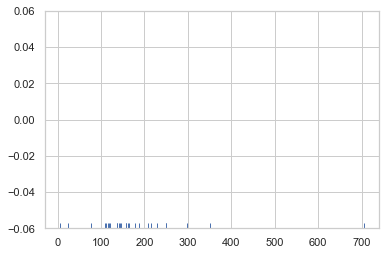

In [171]:
values = dataframes[0]["TIME042"].values.astype(float)
sns.rugplot();

<AxesSubplot:ylabel='TIME042'>

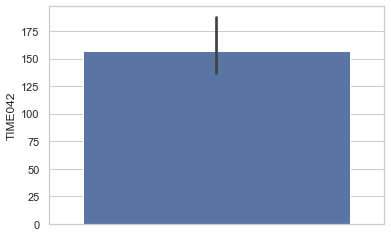

In [181]:
#concat dataframes here
sns.barplot(y="TIME042", data=dataframes[0], estimator=np.median)

<AxesSubplot:ylabel='TIME042'>

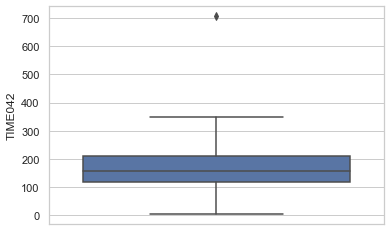

In [182]:
#concat dataframes here
sns.boxplot(y="TIME042",data=dataframes[0])

<AxesSubplot:>

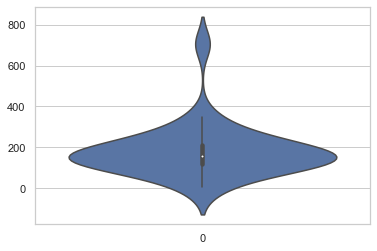

In [186]:
values = dataframes[0]["TIME042"].values.astype(float)
sns.violinplot(data=values)

<h3> Areas of Interest </h3>